The goal of the script is to examine and understand log-transformed features.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from get_data import *

In [2]:
raw_data_frame = load_data_frames()
sectors = ['consumerDiscrete', 'consumerStaples', 'industrials']

When Tim did log-transformation, he did is on the matrix column `[0, 1, 2, 16, 17, 18, 19]`, these columns corresponds to the `raw_data_frame[0].columns[.]`. Let's take a look at these columns

In [3]:
log_transform_columns =  [0, 1, 2, 16, 17, 18, 19]
log_transform_col_names = []
for col in log_transform_columns:
    log_transform_col_names.append(raw_data_frame[0].columns[col])
print log_transform_col_names

['t_ev', 't_rev', 'ebitda', 'capex_as_percent_rev', 'ebitda/interest_exp', 't_debt/cap_percent', 't_debt/equity_percent']


### Distributions across three sectors of these features

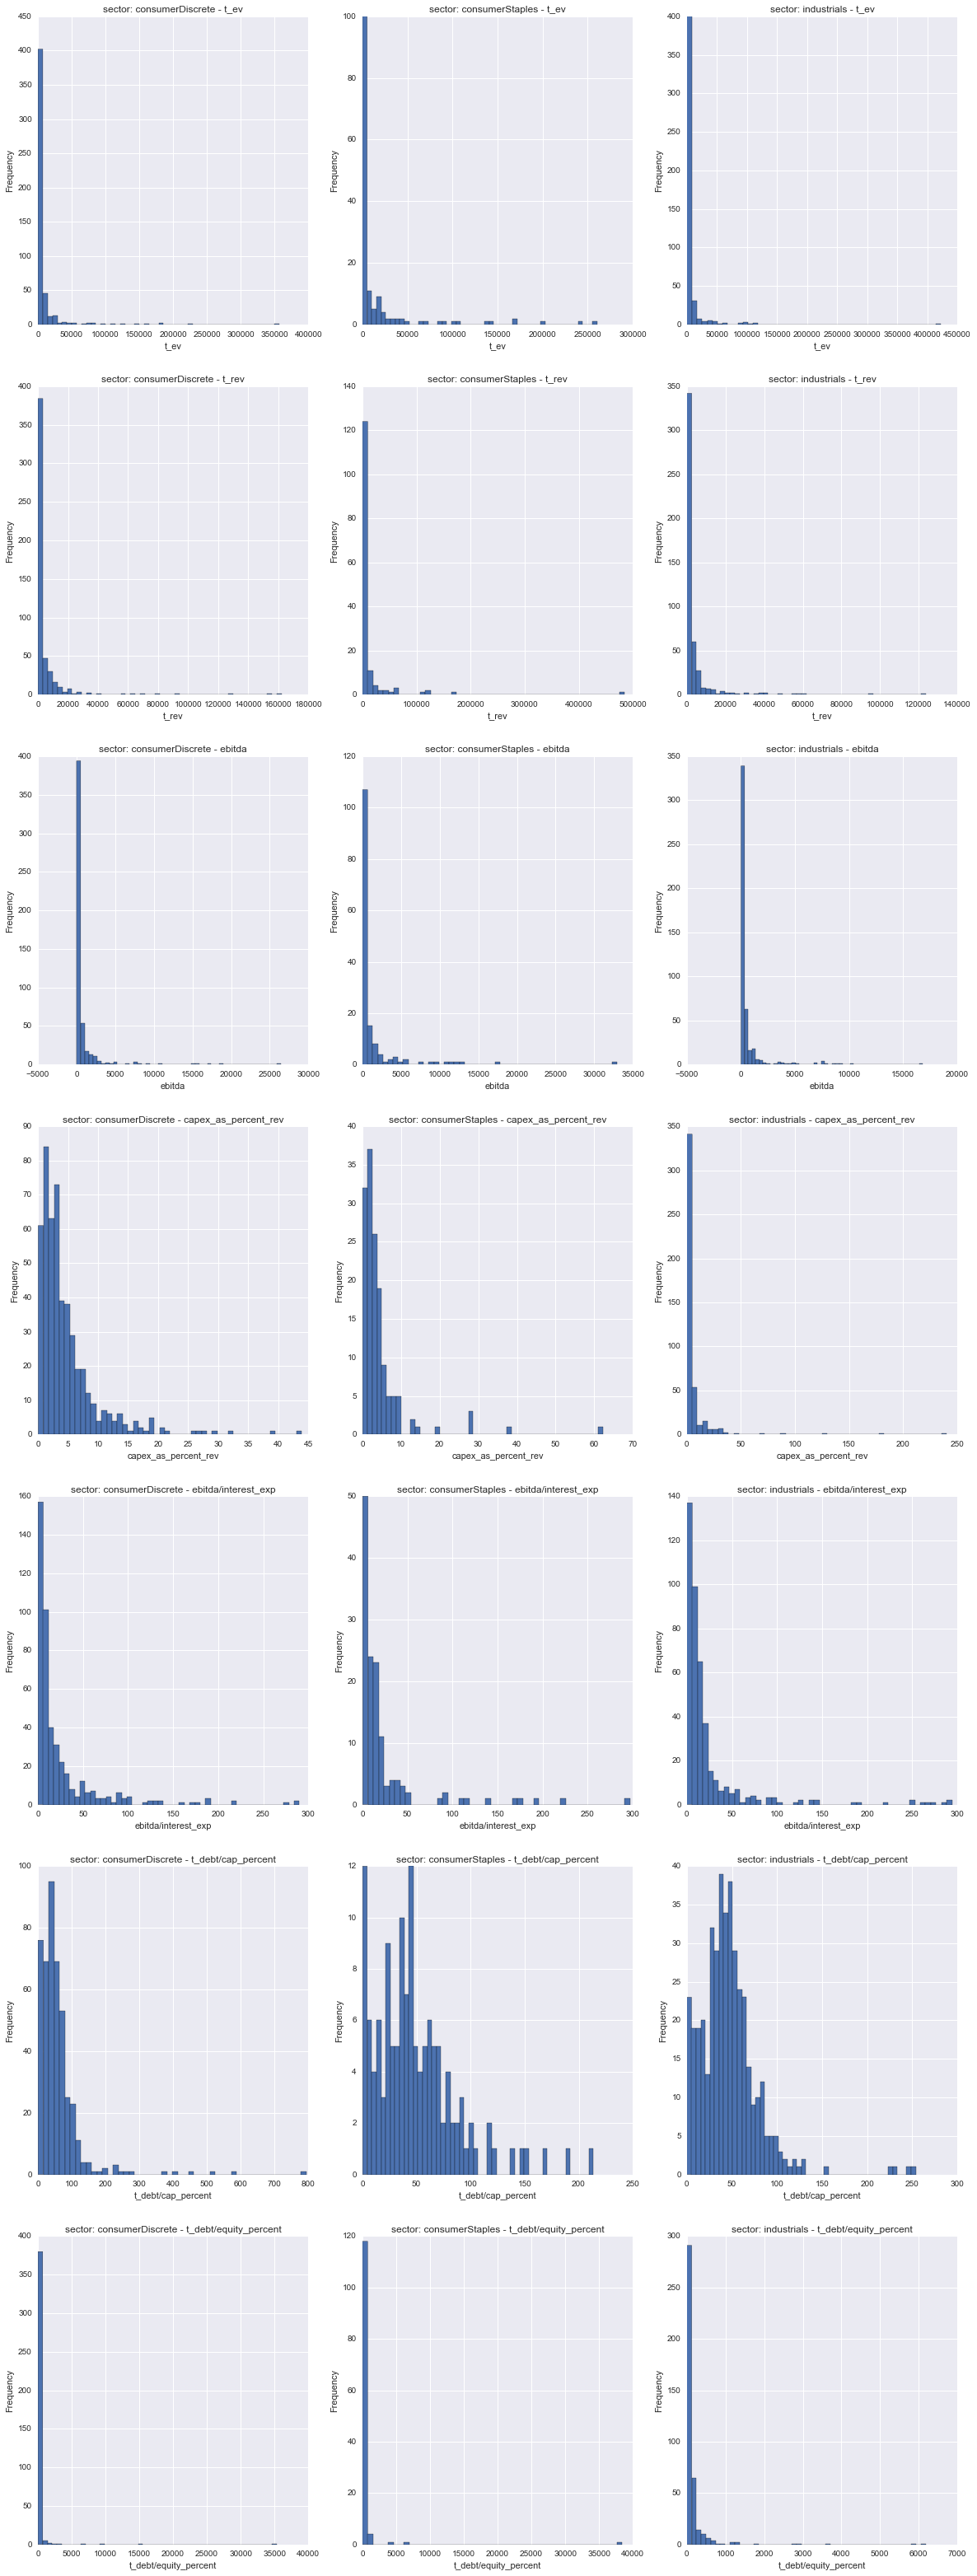

In [4]:
fig, ax = plt.subplots( 7, 3, figsize=(20, 55) )
a = ax.flatten()

for i, col in enumerate(log_transform_col_names):
    for j in range(3):
        raw_data_frame[j][col].plot( 'hist', bins=50, ax=a[i*3+j] )
        a[i*3+j].set_title( 'sector: ' + sectors[j] + ' - ' + col )
        a[i*3+j].set_xlabel( col )

Okay, across three sectors, the distributions are all skewed.

In [5]:
# log-transform inplace
for i in range(len(sectors)):
    raw_data_frame[i][log_transform_col_names] = raw_data_frame[i][log_transform_col_names].apply(np.log10)

## After log-transformation, the distributions

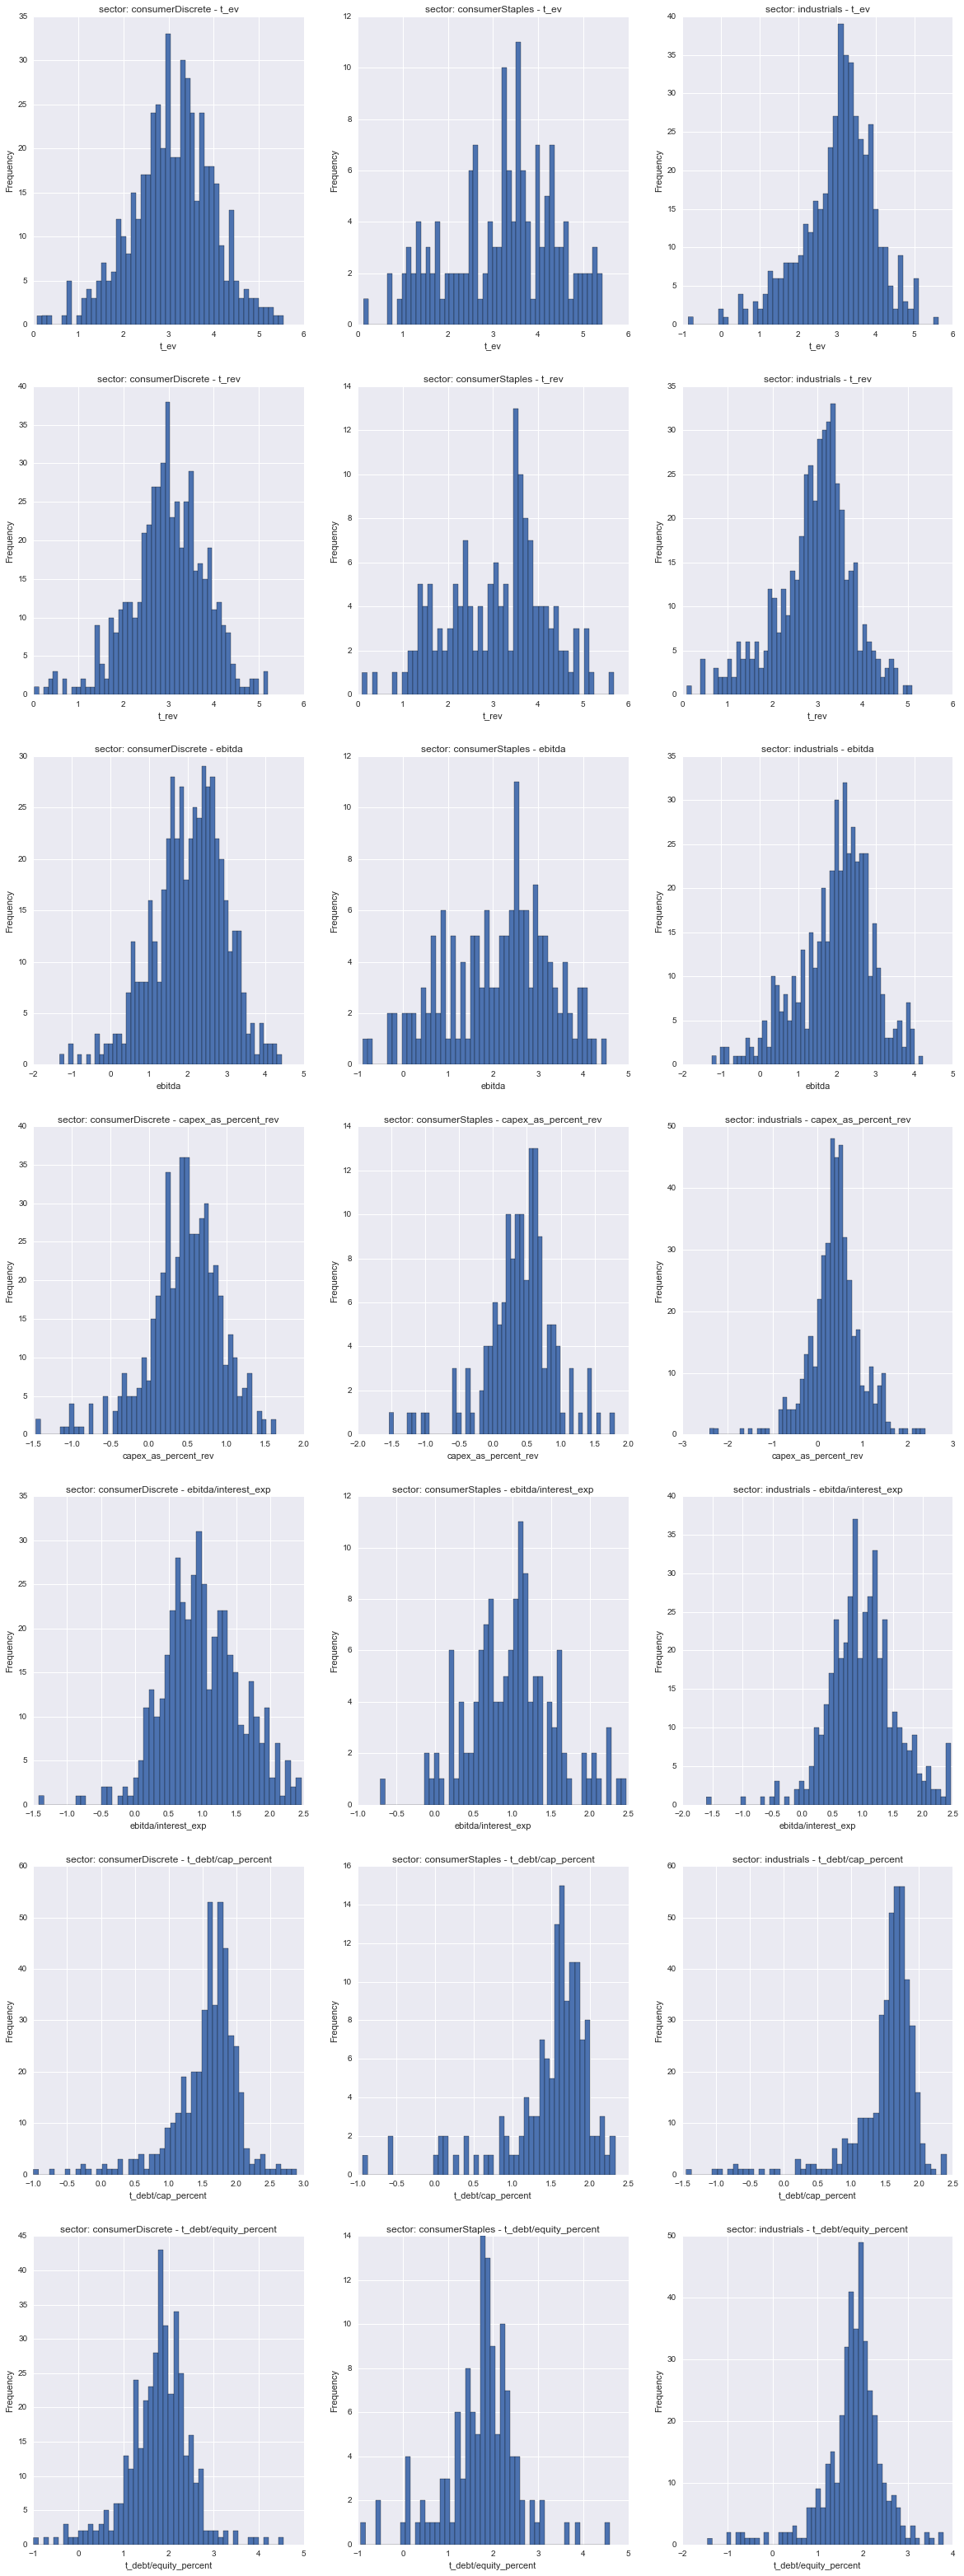

In [6]:
fig, ax = plt.subplots( 7, 3, figsize=(20, 55) )
a = ax.flatten()

for i, col in enumerate(log_transform_col_names):
    for j in range(3):
        raw_data_frame[j][col].plot( 'hist', bins=50, ax=a[i*3+j] )
        a[i*3+j].set_title( 'sector: ' + sectors[j] + ' - ' + col )
        a[i*3+j].set_xlabel( col )

## Mean-fill NaNs

In [7]:
for i in range(len(sectors)):
    raw_data_frame[i].fillna(raw_data_frame[i].mean(), inplace=True)

## Prepare the data for ML models

- Target: 't_ev/ebitda'
- Discard 't_ev'

From pearson correlation heatmap, we see that target variable is not strongly linearly associated with other features. Therefore, I think the nonlinear methods, like tree-based methods, or SVM with nonlinear kernels will outperform. However, one thing to notice is that our final goal is not trying to predict the target value but to understand the complex relationship it has with others. But let's see how various methods works for now.

In [8]:
# drop 't_ev' columns
for i in range(len(sectors)):
    raw_data_frame[i].drop('t_ev', axis=1, inplace=True)
    raw_data_frame[i].drop('t_ev/t_rev', axis=1, inplace=True)

My first trial shows the prediction from OLS for `t_ev/ebitda` is really bad. Even though linear methods don't suppose to work well. However, it makes me wonder what's the distribution of target. 

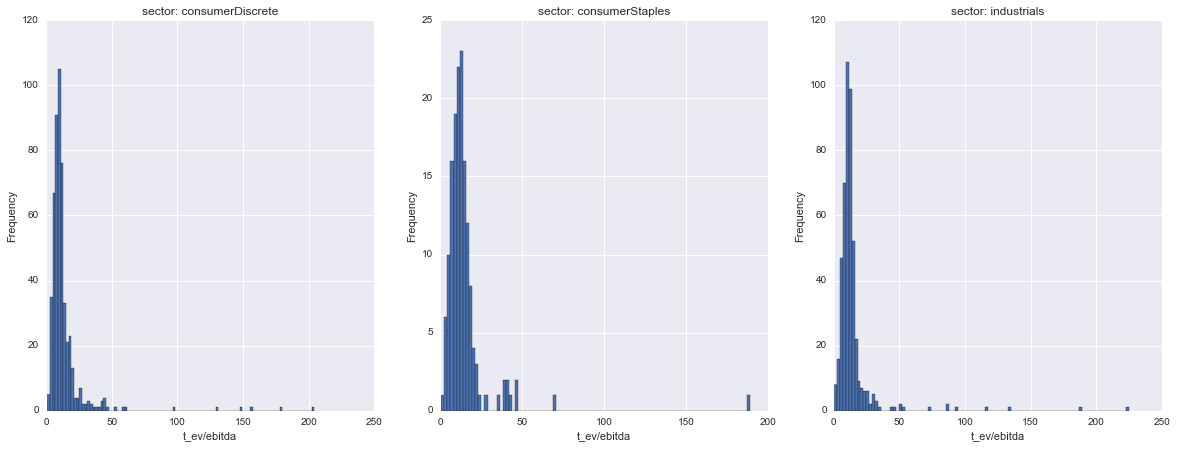

In [26]:
fig, ax = plt.subplots( 1, 3, figsize=(20, 7) )
a = ax.flatten()
for j in range(3):
    raw_data_frame[j]['t_ev/ebitda'].plot( 'hist', bins=100, ax=a[j] )
    a[j].set_title( 'sector: ' + sectors[j])
    a[j].set_xlabel( 't_ev/ebitda' )

If we log-transform `t_ev/ebitda`, do distributions look better?

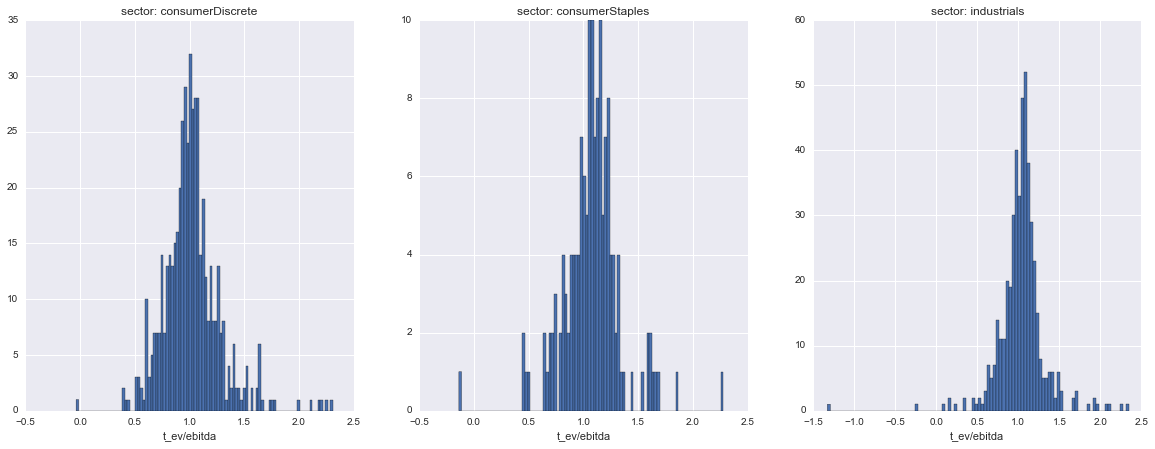

In [30]:
fig, ax = plt.subplots( 1, 3, figsize=(20, 7) )
a = ax.flatten()
for j in range(3):
    a[j].hist(np.log10(raw_data_frame[j]['t_ev/ebitda']), bins=100)
    a[j].set_title( 'sector: ' + sectors[j])
    a[j].set_xlabel( 't_ev/ebitda' )

Indeed, after log-transformation, my brief trial shows that the mean square error decreases dramatically for OLS model!

### Ridge and Lasso regression

In [9]:
print("Let's look at " + sectors[0])
cur_df = raw_data_frame[0]

Let's look at consumerDiscrete


In [13]:
y = cur_df['t_ev/ebitda']
X = cur_df.drop('t_ev/ebitda', axis=1)
X.head()

,t_rev,ebitda,ebitda_margin,est_ann_rev_gr_1yr,est_ann_ebitda_gr_1yr,t_rev_1yr_growth,ebitda_1yr_growth,t_rev_3_yr_cagr,ebitda_3yr_cagr,t_rev_5yr_cagr,ebitda_5yr_cagr,return_on_assets,return_on_equity,capex_as_percent_rev,ebitda/interest_exp,t_debt/cap_percent,t_debt/equity_percent
0,3.075182,1.897077,6.64,4.540000,16.700000,2.06000,-0.852000,16.400000,19.400000,11.200000,18.700000,4.600000,9.900000,0.460898,1.103804,1.513218,1.685742
1,2.426511,0.772322,2.22,7.132813,17.742803,-1.93000,13.234825,-4.040000,-34.500000,-10.600000,-28.900000,-1.570000,-12.200000,0.444045,1.004171,1.561461,1.781483
2,3.509740,2.665393,14.30,1.480000,4.270000,4.08000,4.980000,13.000000,9.600000,10.300000,11.200000,9.930000,9.950000,0.278754,1.281033,1.489958,1.650308
3,3.531900,2.415808,7.65,-5.230000,-36.900000,-3.46000,-19.200000,-7.400000,-21.700000,-3.080000,-15.300000,1.560000,1.330000,0.609594,1.060698,1.311754,1.411620
4,3.191898,2.244277,11.30,7.132813,17.742803,331.70347,13.234825,12.670764,8.528391,8.063843,7.665472,6.344578,14.769923,0.187521,0.481443,1.857332,2.411114


In [31]:
from sklearn.preprocessing import scale
X_scale = scale(X)
y_scale = np.log10(y)

#### OLS

Normalize using the option within the function

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

ols_model = LinearRegression(normalize=True)
scores = cross_val_score(ols_model, X_scale, y_scale, cv=5, scoring="mean_squared_error")

/Users/xinyutan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xinyutan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xinyutan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xinyutan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_

In [33]:
print scores

[ -0.05871511  -0.05404501  -0.08627334 -11.75592573  -0.28351318]
